In [ ]:
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [3]:
# Root directory for dataset
dataroot = "/hdd_c/sri/CelebA/64/"

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 32

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 1

# Learning rate for optimizers
lr_D = 0.0002
lr_G = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

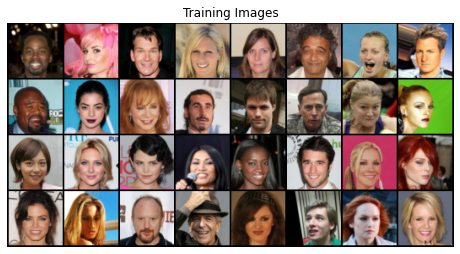

In [13]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, drop_last=True)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))

# print(np.min(real_batch[0][0].numpy()))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=False).cpu(),(1,2,0)))

In [5]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [37]:
# Variational Autoencoder Code
'''Sub class the nn module'''
class AE(nn.Module):
    def __init__(self, ngpu):
        super(AE, self).__init__() #not a python thing
        self.ngpu = ngpu
        
        self.encoder = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            Flatten()
        )
        
        self.fc1 = nn.Linear(ndf*8*4*4, nz)
        self.fc2 = nn.Linear(ndf*8*4*4, nz)
        self.fc3 = nn.Linear(nz, ndf*8*4*4)
        
        self.decoder = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( ndf*8*4*4, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Sigmoid()
            # state size. (nc) x 64 x 64
        )
        
    def reparameterize(self, mu, logvar, eps):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        z = mu + (std*eps)
        return z
    
    def bottleneck(self, h, eps):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar, eps)
        return z, mu, logvar

    def encode(self, x, eps):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h, eps)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = z.unsqueeze(-1).unsqueeze(-1)
        x = self.decoder(z)
        return x

    def forward(self, x, eps):
        z, mu, logvar = self.encode(x,eps)
        x = self.decode(z)
        return x, mu, logvar


# Create the generator
netAE = AE(ngpu) #.to(device) # adding it to the device

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netAE = nn.DataParallel(netAE)
    
netAE.to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netAE.apply(weights_init)

# Print the model
print(netAE)
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

AE(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Flatten()
  )
  (fc1): Linear(in_features=8192, out_features=100, bias=True)
  (fc2): Linear(in_features=8192, out_features=10

In [38]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

# Setup Adam optimizers for both G and D
optimizerAE = optim.Adam(netAE.parameters(), lr=lr_G, betas=(beta1, 0.999))

In [39]:
# Training Loop

# Lists to keep track of progress
AE_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update AE network
        ###########################
        ## Train with all-real batch
        netAE.zero_grad() 
        
        img = data[0].to(device) 
        b_size = img.size(0)
        esp = torch.randn(b_size, nz, device=device)
        recon_images, mu, logvar = netAE(img,esp)
        errAE, bce, kld = loss_fn(recon_images, img, mu, logvar)
        optimizerAE.zero_grad()
        errAE.backward()
        optimizerAE.step()
        
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_VAE: %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errAE.item()))
            
        iters += 1

Starting Training Loop...
[0/1][0/6331]	Loss_VAE: 272842.9375
[0/1][50/6331]	Loss_VAE: 215122.0625
[0/1][100/6331]	Loss_VAE: 227182.7031
[0/1][150/6331]	Loss_VAE: 213671.5625
[0/1][200/6331]	Loss_VAE: 199427.4062
[0/1][250/6331]	Loss_VAE: 204912.8125
[0/1][300/6331]	Loss_VAE: 203911.0000
[0/1][350/6331]	Loss_VAE: 200821.6094
[0/1][400/6331]	Loss_VAE: 216755.9844
[0/1][450/6331]	Loss_VAE: 214019.4688
[0/1][500/6331]	Loss_VAE: 207620.3438
[0/1][550/6331]	Loss_VAE: 200986.4219
[0/1][600/6331]	Loss_VAE: 200068.3281
[0/1][650/6331]	Loss_VAE: 192681.6250
[0/1][700/6331]	Loss_VAE: 203039.2656
[0/1][750/6331]	Loss_VAE: 195115.0938
[0/1][800/6331]	Loss_VAE: 201749.5156
[0/1][850/6331]	Loss_VAE: 197012.9219
[0/1][900/6331]	Loss_VAE: 202304.2656
[0/1][950/6331]	Loss_VAE: 198260.8594
[0/1][1000/6331]	Loss_VAE: 200690.1406
[0/1][1050/6331]	Loss_VAE: 206433.0000
[0/1][1100/6331]	Loss_VAE: 199130.6406
[0/1][1150/6331]	Loss_VAE: 203781.1562
[0/1][1200/6331]	Loss_VAE: 203545.3594
[0/1][1250/6331]	Loss_

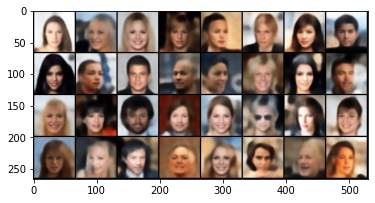

In [40]:
with torch.no_grad():
    data = next(iter(dataloader))
    img = data[0].to(device)
    eps = torch.randn(img.size()[0], nz, device=device)
    grid,_,_ = netAE(img,eps)
    grid = grid.detach().cpu()
    plt.imshow(np.transpose(vutils.make_grid(grid, padding=2, normalize=False).cpu(),(1,2,0)))
        

In [66]:



# Generator Code
'''Sub class the nn module'''
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__() #not a python thing
        self.ngpu = ngpu
        self.encoder = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            Flatten()
        )
        
        self.decoder = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( ndf*8*4*4, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Sigmoid()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
#         eps = torch.randn(b_size, 3, 64, 64, device=device)
        enc = self.encoder(input)
        enc = enc.unsqueeze(-1).unsqueeze(-1)
        return self.decoder(enc)

# Create the generator
netG = Generator(ngpu).to(device) # adding it to the device

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Flatten()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8192, 512, kernel_size=(4, 4), stride=(1, 1), bias=Fals

In [67]:

    
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(2*nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            Flatten(),
            nn.Linear(ndf*8*4*4,1),
#             nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, image, label):
        input = torch.cat((image,label),1)
        return self.main(input)

# Create the Discriminator
netD = Discriminator(ngpu).to(device) #addting it to the device

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Flatten()
    (12): Linear(in_features=8192, out_features=1, bias=True)
    (13): Sigmoid()
  )
)


In [ ]:
def plot():
    with torch.no_grad():
        data = next(iter(dataloader))
        img = data[0].to(device)
        b_size = real_cpu.size(0)
        eps = torch.randn(b_size, nz, device=device)
        grid,_,_ = netAE(img,eps)
        grid = grid.detach().cpu()
        plt.figure(figsize=(8,8))
        plt.axis("off")
        plt.title("AE Reconstruction")
        plt.imshow(np.transpose(vutils.make_grid(grid, padding=2, normalize=False).cpu(),(1,2,0)))

        grid = netG(grid.to(device)).detach().cpu()
        plt.figure(figsize=(8,8))
        plt.axis("off")
        plt.title("GAN Reconstruction")
        plt.imshow(np.transpose(vutils.make_grid(grid, padding=2, normalize=False).cpu(),(1,2,0)))
        plt.show()

In [68]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size*2, nz, 1, 1, device=device) #adding it to the device

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr_D, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_G, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(5*num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad() #zero out the gradient buffer. I don't think I know what this is exactly
        # Format batch
        real_cpu = data[0].to(device) #not sure why this is called real_cpu since the device is set to GPU
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device) #why not use the batch_size param here.
        
        with torch.no_grad():
            noise = torch.randn(b_size, nz, device=device)
            class_,_,_ = netAE(real_cpu,noise)
            class_ = class_.detach()
        
        
        # Forward pass real batch through D
        output = netD(real_cpu,class_).view(-1) 
        errD_real = criterion(output, label)  
        errD_real.backward() 
        D_x = output.mean().item() 

        ## Train with all-fake batch
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(class_)
        label.fill_(fake_label)
        
        # Classify all fake batch with D
        output = netD(fake.detach(),class_).view(-1) 
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
 
        errD = errD_real + errD_fake
        optimizerD.step() 

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  
        output = netD(fake,class_).view(-1) 
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        if i % 1000 == 0:
            plot()
        
            
        iters += 1